# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import HTML
table_css = 'table {align:left;display:block} '
HTML('<style>{}</style>'.format(table_css))

In [2]:
batting = pd.read_csv('../data/war_daily_bat.txt')
positions = pd.read_csv('../data/majors_appearances.csv')
schedules = pd.read_csv('../data/Teams.csv')

In [3]:
# pythonize columns
batting.columns = [col.lower() for col in batting.columns]
positions.columns = [col.lower() for col in positions.columns]
schedules.columns = [col.lower() for col in schedules.columns]

In [4]:
# reduce schedules to the effective columns
schedules = schedules[['yearid','g','teamidbr']]
schedules.rename(columns={'yearid': 'year_id',
                          'g': 'gp',
                          'teamidbr': 'team_id'},
                 inplace=True)

In [5]:
# drop columns not needed for this analysis
batting.drop(['salary','ops_plus','mlb_id','lg_id','waa_win_perc',
              'waa_win_perc_off','waa_win_perc_def',
              'tob_lg','tb_lg'], axis=1, inplace=True)
positions.drop(['how_acquired','total_season','total_league','g_batting',
                'gs','gs_defense','g_defense','g_ph','g_pr',
                'war_bat','war_pitch','war','team_id','lg_id','experience'],
               axis=1, inplace=True)



|Dataset| # Records | # of Columns|  
| ---------------------------------- | ----------- |---|
|**batting**| 119,681       |41|
|**positions**|120,131|20|
|**schedules**|2,985|3|

# Data Dictionary
## Player variables
| Column | *dtype* | Description |
| :-- | :-- | :-- |
| name_common | *str* | Name of player |
| age | *float* | Player’s age at midnight of June 30th of that year |
| player_id | *str* | String-based UID generated as a function of name_common in baseball-reference database |
| year_id | *int* | Year the season took place |
| stint_ID | *int* | Order of team played for. 1 for first team, 2 for second, etc. |
| G | *int* | This includes all times that the player appeared on the lineup card. Pitchers in non-DH games that appeared on the lineup card but didn't bat will still have a game in this column. |
| pitcher | *bool* | Indicator for player is a pitcher. |


--------------------


## Batter-side variables
| Column | *dtype* | Description |
| :-- | :-- | :-- |
| PA | *float* | When available, we use actual plate appearances from play-by-play game accounts. Otherwise estimated using AB + BB + HBP + SF + SH, which excludes catcher interferences. |
| Inn | *float* | Innings played |


-------------------


## Position variables
| Column | *dtype* | Description |
| :-- | :-- | :-- |
| G_p | *int* | Games in which the pitcher position was played |
| G_c | *int* | Games in which the catcger position was played |
| G_1b | *int* | Games in which the first base position was played |
| G_2b | *int* | Games in which the second base position was played |
| G_3b | *int* | Games in which the third base position was played |
| G_ss | *int* | Games in which the short stop position was played |
| G_lf | *int* | Games in which the left field position was played |
| G_cf | *int* | Games in which the center field position was played |
| G_rf | *int* | Games in which the right field position was played |
| G_of | *int* | Games in which any outfield position was played |
| G_dh | *int* | Games in which the designated hitter position was played |


--------------------


## Runs variables
| Column | *dtype* | Description |
| :-- | :-- | :-- |
| runs_bat | *float* | Number of runs better or worse than average the player was as a hitter. This is based on a modified version of wRAA. |
| runs_br | *float* | Number of runs better or worse than average the player was for all baserunning events. SB, CS, PB, WP, Defensive Indifference. |
| runs_dp | *float* | Number of runs better or worse than average the player was at avoiding grounding into double plays. |
| runs_field | *float* | Fielding Range Plus/Minus Runs Saved based on BIS-trained scorer observations and batted ball timing to determine the velocity of each batted ball. |
| runs_infield | *float* | double plays and bunts |
| runs_outfield | *float* | outfield arms |
| runs_catcher | *float* | catcher defense |
| runs_good_plays | *float* | home run saving catches |
| runs_defense | *float* | Number of runs better or worse than average the player was for all fielding. Fielding of balls in play, turning double plays, outfield arms and catcher defense are all included. |
| runs_position | *float* | Number of runs above or below average due to positional differences. Positions like C, SS, and 2B get a bonus. Positions like 1B, DH, LF get a penalty. |
| runs_position_p | *float* | Positional adjustment for pitchers because they bat as well and need a fielding adjustment |
| runs_above_avg | *float* | Runs from Replacement Level - Number of runs an average player is better than a replacement player. Replacement is set for a .294 team winning percentage. |
| runs_above_avg_off | *float* | Number of batting runs an average player is better than the batting runs of a replacement player. (no runs defense) |
| runs_above_avg_def | *float* | Number of fielding runs an average player is better than the fielding runs of a replacement player. (runs defense AND runs position) ... adding off and def does double count runs position FYI |

--------------------


## WAA variables
| Column | *dtype* | Description |
| :-- | :-- | :-- |
| WAA | *float* | Wins Above Avg - This is the wins added by this player above that of an average player. We compute the waaW-L% using a PythagenPat conversion and then subtract .500 and multiply by the number of games |
| WAA_off | *float* | Offensive Wins Above Average |
| WAA_def | *float* | Defensive Wins Above Average |


--------------------


## Pythagorean
| Column | *dtype* | Description |
| :-- | :-- | :-- |
| teamRpG | *float* | an avg team runs scored with this player |
| oppRpG | *float* |  an avg team runs allowed with this player |
| pyth_exponent | *float* |  pythagenpat exponent based on run environment for avg teams where pythagenpat = ((rs + ra)/g)^.285 |

The amount of data, as well as the amount of variables, will allow us to proceed with our project. The breakout of WAR, WAA, and runs by their respective portions should give be able to give us a deeper dive into modeling WAR against a baseline of the player's weighted average WAR in their lookback window.

The nature of the batting and positions tables will make trending across years simple since each row represents one or part of one season. There will be little unpacking to create a year-by-year lookback for a players WAR or other stats.

# Data Munge

## Years and Eras

Baseball fans, reporters, historians, and statisticians tend to agree that there are different eras for baseball. They have names like "dead-ball era", "live-ball era", "post-war", "steroid era", etc. The lively debate online is not whether they exist but the lines of demarcation between the eras.

For this analysis, we will examine the league starting in the "expansion era" which is commonly described as starting in 1962 due to the increase in the number of teams in the league. This will have a few benefits:
  1.  The number of teams will be at least 20
  2.  It excludes years with sparse game information, allowing for better data completeness
  3.  The schedule was standardized to 162 games by this point
  
On the other side, the data will end in 2019 due to a shortened season in 2020 because of the COVID-19 pandemic.

In [6]:
# remove pre-1962 and post-2019 data
batting = batting[(batting.year_id > 1961) & (batting.year_id < 2020)]
positions = positions[(positions.year_id > 1961) & (positions.year_id < 2020)]
schedules = schedules[(schedules.year_id > 1961) & (schedules.year_id < 2020)]


|Dataset| # Records | # of Columns|  
| ---------------------------------- | ----------- |---|
|**batting**| 65,444       |41|
|**positions**|65,445|20|
|**schedules**|1,548|3|

### Incomplete/Non-full Seasons

Not every season contains the same amount of games. Not every team plays the same amount of games within a season. Some notable exceptions are:
  -  1972: Strike. Range of games played from 156 to 153
  -  1981: Strike. Range of games played from 111 to 102
  -  1994: Strike. Range of games played from 117 to 112
  -  1995: Strike. Games reduced to 144
  
To keep track of this, the schedules dataframe will be used to provide the number of games each team played in a season. Currently, each player in the batting dataframe is separated by team stint, meaning a simple lookup to their team and year to get the games played by that team.

In [7]:
# merge batting and schedules to get the number of games a team_id played per
# year_id
batting = pd.merge(batting, schedules,
                   on = ['year_id','team_id'])

batting.rename(columns={'gp': 'team_gp'},
               inplace=True)

## Null Values - Batting

In [8]:
batting[batting.columns[batting.isnull().any()]].isnull().sum()\
                                            .to_frame("# of Nulls")\
                                            .sort_values('# of Nulls',
                                                         ascending = False)

,# of Nulls
runs_good_plays,41336
war,8234
war_off,8234
war_rep,8234
waa,7799
waa_off,7799
waa_def,7799
war_def,7799
teamrpg,7799
opprpg_rep,7799


There are a significant number of nulls for `runs_good_plays` as well as for our target variable WAR.

### `runs_good_plays` nulls

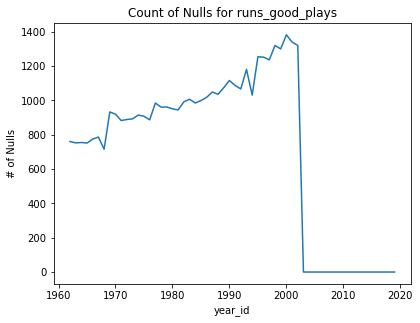

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (6.4,4.8))
ax.plot(batting.isnull().groupby(batting['year_id']).sum().runs_good_plays)
ax.set_title('Count of Nulls for runs_good_plays')
ax.set_ylabel('# of Nulls')
ax.set_xlabel('year_id');

`runs_good_plays` only has values from 2003 onward. Baseball-Reference changed their fielding/defense runs values from TZR (total zone rating) to DRS (defensive runs saved) in 2003. `runs_good_plays` is a variable only present in DRS.

This brings up a watershed moment for fielding, we know:
```python
runs_defense = runs_field + runs_infield + runs_outfield + runs_catcher + runs_good_plays
```
The way each of those components is calculated is changed by whether it was a TZR or DRS measurement. For this reason, they cannot be compared at this level of detail if the analysis is to include years before and after 2003, and must be dropped.

In [10]:
# drop everything except runs_defense
batting.drop(['runs_field',
              'runs_infield',
              'runs_outfield',
              'runs_catcher',
              'runs_good_plays'], axis=1, inplace=True)

### `WAR` nulls

In [11]:
batting[batting.war.isnull()][['war','war_off','war_rep']].value_counts(dropna=False)

war  war_off  war_rep
NaN  NaN      NaN        8234
dtype: int64

**Observation** all `WAR` nulls coincide with at least one nulls for `war_off`, `war_rep`

Our target variable has some significant data missingness. It may be possible to impute these values logically through the other columns in our dataframe, but first we need to examine how WAR is calculated.


**A brief review of WAR**

WAR stands for Wins Above Replacement and is calculated by determining the number of runs a player is responsible for and then extrapolating that to the number of runs that is above the average league player. This is called WAA. Translating from WAA to WAR includes a calculation called WAR_rep which is meant to represent the gap between an average player and a replacement one.

```Python
runs_above_avg = runs_bat + runs_br + runs_dp + runs_defense + runs_pos
f(runs_above_avg | year season played) = WAA
g(runs_above_avg | year season played) = WAR_rep
WAR = WAR_rep + WAA
```

At the end of the day; runs, WAA, and WAR can all be decomposed
```python
runs_above_avg = runs_above_avg_off + runs_above_avg_def - runs_pos
WAA = WAA_off + WAA_def - WAA_position
WAR = WAR_off + WAR_def - WAR_pos, where WAR_off = WAA_off + WAR_rep
```

Our dataset does not include WAA_position or WAR_position, but they can be computed
```python
WAA_position = WAA_off + WAA_def - WAA
WAR_position = WAA_position
```

This brings us to an issue however. 
```python
WAA_position = WAR_position
WAA_def = WAR_def
```
How can these statments be true? Why isn't there a average-to-replacement value adjustment occurring between these steps?

Unfortunately, we are black-boxed here. WAR_rep, as seen in the WAR_off calculation above, is an adjustment to center WAR to the amount of wins available in the league, but it seems incorrect that the adjustment doesn't apply to both off and def. 

**For this reason, we will refocus our analysis on a new target variable: WAA.**

In [12]:
# drop WAR from batting
batting.drop(['runs_replacement','runs_above_rep','war','war_def','war_off',
              'war_rep','opprppa_rep','opprpg_rep','pyth_exponent_rep',
              'waa_win_perc_rep'],
             axis = 1,
             inplace=True)

In [13]:
# create WAA_position
batting['waa_pos'] = batting['waa_off'] + batting['waa_def'] - batting['waa']

### `pitcher` nulls

The `pitcher` flag is to identify players in the batting dataset that were not primarily batters, but rather pitchers. For the purposes of this analysis, we only want non-pitchers! But before we can filter them out, we need to fill the nulls.

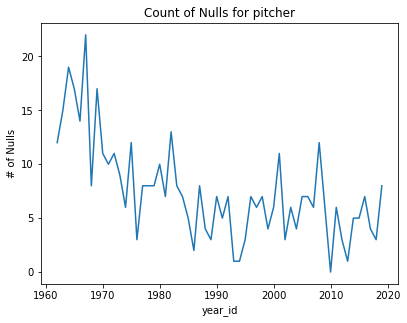

In [14]:
fig, ax = plt.subplots(1, 1, figsize = (6.4,4.8))
ax.plot(batting.isnull().groupby(batting['year_id']).sum().pitcher)
ax.set_title('Count of Nulls for pitcher')
ax.set_ylabel('# of Nulls')
ax.set_xlabel('year_id');

**Observation** No years that indicate a clear end or beginning of the nulls in the dataset.

In [15]:
batting[batting.pitcher.isnull()].runs_position_p.describe()

count    435.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: runs_position_p, dtype: float64

None of these nulls logged runs_position for p. Good indicator that they are most likely not pitchers.

In [16]:
# aggregate positions db by player-year to determine the true position of 
# the players
pos_agg = positions\
            .groupby(['year_id','player_id']).sum().reset_index()

In [17]:
# aggregate batting db by player-year to create the same level-of-detail with
# the positions table
bat_pos_agg = pos_agg.merge(batting[batting.pitcher.isnull()],
                 on=['year_id','player_id'])

In [18]:
bat_pos_agg[bat_pos_agg.g_p>0]

,year_id,player_id,g_all,g_p,g_c,g_1b,g_2b,g_3b,g_ss,g_lf,...,runs_above_avg_def,waa,waa_off,waa_def,pitcher,teamrpg,opprpg,pyth_exponent,team_gp,waa_pos
380,2008,owingmi01,40,22,0,0,0,0,0,0,...,0.0,0.10,0.10,0.0,NaN,4.89936,4.64186,1.902,162,0.0
427,2019,altheaa01,49,1,0,0,0,0,0,14,...,0.0,-0.03,-0.03,0.0,NaN,4.44014,4.72014,1.880,162,0.0


**Observation** 433 of 435 nulls have zero games at picher and can imputed as 'N'

Looking the remaining two players up on baseball-reference, owingmi01 is a pitcher and altheaa01 is not a pitcher

In [19]:
# update owingmi01
batting.loc[(batting['year_id']==2008) & 
            (batting['player_id']=='owingmi01') &
            (batting['stint_id']==2),
            'pitcher'] = 'Y'

# update altheaa01
batting.loc[(batting['year_id']==2019) & 
            (batting['player_id']=='altheaa01') &
            (batting['stint_id']==2),
            'pitcher'] = 'N'

In [20]:
# now every remaining null is 'N'
batting['pitcher'] = batting['pitcher'].map(lambda x: 'N' if pd.isnull(x) else x)

In [21]:
# we only care about non-pitchers. Drop the pitchers
batting = batting[batting.pitcher == 'N']

In [22]:
# no longer need these pitcher attributes
batting.drop(['pitcher','runs_position_p'], axis=1, inplace=True)

In [23]:
batting[batting.columns[batting.isnull().any()]].isnull().sum()\
                                            .to_frame("# of Nulls")\
                                            .sort_values('# of Nulls',
                                                         ascending = False)

,# of Nulls


And we are done with nulls for batting!

## Null Values - Positions

In [24]:
positions[positions.columns[positions.isnull().any()]].isnull().sum()\
                                            .to_frame("# of Nulls")\
                                            .sort_values('# of Nulls',
                                                         ascending = False)

,# of Nulls


There are zero nulls in positions

# Batting EDA

## Pre-Stint Aggregation

### `team_id`

No longer need `team_id` as it was only used to get us the games played by team by season.

In [25]:
# drop
batting.drop('team_id', axis=1, inplace=True)

### `teamrpg`

`waa` is determined through many helper variables that attempt to adjust to the league environment at the time.

`teamrpg` is a calculation of how a player affected an average team's run production, where the average team is calculated for the year and league. However, looking at `teamrpg` will already include the waa effect of a player and doesn't tell us the environment in which the waa was achieved.

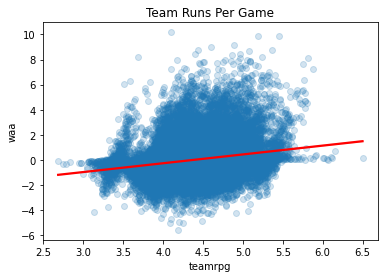

In [26]:
sns.regplot(x='teamrpg', y='waa', data = batting,
            scatter_kws={'alpha': 0.2},
            line_kws={'color': 'red'}).set(title = 'Team Runs Per Game');

**Note** This *includes* the team runs per game with the player's runs added.

However, we can remove a player's impact from the theoretical average team to get a figure for what an average team looked like that season.

In [27]:
# multiply teamrpg by the number of games that team played
teamrpg_total = batting.teamrpg*batting.team_gp

# calculate the total number of runs a player earned
runs_off = (batting.runs_bat + batting.runs_br + batting.runs_dp \
           + batting.runs_position)

# scale that number of runs to a full season
runs_off_season = runs_off * batting.team_gp / batting.g

# subtract the scaled number from the total number of team runs
# divide by the games in the season to get back to a per-game basis
batting['teamrpg_avg'] = (teamrpg_total - runs_off_season)/batting.team_gp

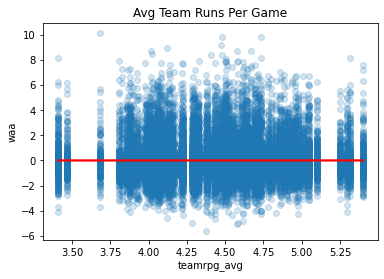

In [28]:
sns.regplot(x='teamrpg_avg', y='waa', data = batting,
            scatter_kws={'alpha': 0.2},
            line_kws={'color': 'red'}).set(title = 'Avg Team Runs Per Game');

Each band of values for `teamrpg_avg` is an instance of year_id and lg_id

### `opprpg`

Similarly, opprpg is a metric on the average opponent's run production in games against the player. Baseball-Reference does not adjust this value for batters, only for pitchers. Therefore, no adjustments are needed to get `opprpg` to the league average. 

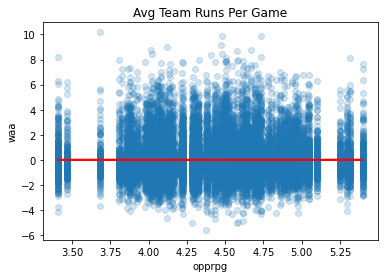

In [29]:
sns.regplot(x='opprpg', y='waa', data = batting,
            scatter_kws={'alpha': 0.2},
            line_kws={'color': 'red'}).set(title = 'Avg Team Runs Per Game');

Here just as in teamrpg_avg, each band of values for `opprpg` is an instance of year_id and lg_id

### `pyth_exponent`

`pyth_exponent` is a function of `teamrpg` and `opprpg`. This does not provide value as it contains a player's effect. However, substituting `teamrpg_avg` and recalculating can give an additional insight into how the year's environment was.

In [30]:
batting['pyth_exponent_avg'] =\
((batting.teamrpg_avg + batting.opprpg)*batting.team_gp)**.285

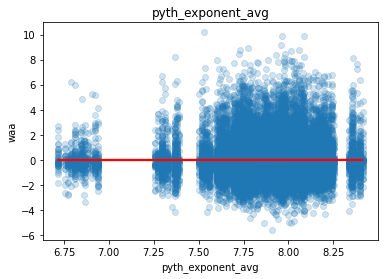

In [31]:
sns.regplot(x='pyth_exponent_avg', y='waa', data = batting,
            scatter_kws={'alpha': 0.2},
            line_kws={'color': 'red'}).set(title = 'pyth_exponent_avg');

Once again, each band is an instance of season and league.

**Conclusion** `teamrpg_avg`, `opprpg`, and `pyth_exponent_avg` all do the same thing: describe the environment of the season.

The calculation for `pyth_exponent_avg` is:  $\ \ \ \ \ (teamrpg\_avg+opprpg)^{0.285}$

The most translatable metric of these three to use is `opprpg` as it is untransformed by player (unlike `teamrpg_avg`) and is not an exponential function of two existing metrics in our dataset (`pyth_exponent_avg`).

In [32]:
# drop
batting.drop(['teamrpg','pyth_exponent', 'teamrpg_avg','pyth_exponent_avg'],
             axis=1, inplace=True)

## Stint Aggregation

When a batter switches teams during a season, they receive a new entry in the batting database. These are kept track in the `stint_id` feature.

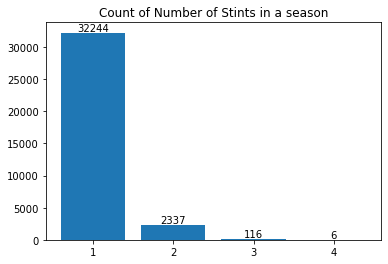

In [33]:
plt.bar(batting.groupby('stint_id').count().reset_index().stint_id,
       batting.groupby('stint_id').count().reset_index().g)
plt.title('Count of Number of Stints in a season')
plt.xticks(range(1,5))
plt.bar_label(plt.gca().containers[0]);

**Observation** Some players switched teams as many as 3 times (for a total of 4 teams) in a season! This means that each player-year combination can be split across that many years."

The level-of-detail we want for this analysis is player-year. To accomplish this, we need to aggregate together `stint_id`

**Aggregations:**

Take Max value of attribute (should be the same across stints)
-  name_common, age, player_id, year_id

Take Sum of rows (additive aggregate features)
-  pa, g, inn, runs_bat, runs_br, runs_dp, runs_defense, runs_position, runs_above_avg, runs_above_avg_off, runs_above_avg_def, waa, waa_off, waa_def, waa_pos

Weighted average of rows (games as factor)
-  opprpg, teamgp

In [34]:
# create the segment that uses max as aggregate
batting_agg = batting.groupby(['player_id','year_id']).max()\
                [['name_common', 'age']]

In [35]:
# create the segment that uses sum as aggregate
batting_sum = batting.groupby(['player_id','year_id']).sum()\
                [['pa', 'g', 'inn', 'runs_bat', 'runs_br', 'runs_dp',
                  'runs_defense', 'runs_position','runs_above_avg',
                  'runs_above_avg_off', 'runs_above_avg_def', 'waa',
                  'waa_off', 'waa_def','waa_pos']]

In [36]:
# create the segment that uses weighted avg as aggregate
batting_weight = batting[['player_id','year_id','stint_id','g',
                          'opprpg','team_gp']]

# for our look-up functions to work, we will need stint_id to be descending
batting_weight = batting_weight.sort_values('stint_id', ascending=False)

In [37]:
# decompose opprpg to use g for weighted avg
batting_weight['opprpg_decomp'] =\
    batting_weight['opprpg']*batting_weight['g']

In [38]:
# for up to the max 4 stints by player-year,
# calculate the total number of games
# played by the player and store that in stint_id = 1

batting_weight['total_games'] = pd.DataFrame(
    [batting_weight.groupby(['player_id','year_id'])['g'].shift(i)
     for i in range(0,4)]).T.sum(axis=1)

In [39]:
# similar to total_games, sum up opprpg_recomp for
# each player-year and store sum in stint_id = 1
# then divide it by total_games to get the weighted average in row of stint_id=1

batting_weight['opprpg_recomp'] = pd.DataFrame(
    [batting_weight.groupby(['player_id','year_id'])['opprpg_decomp'].shift(i)
     for i in range(0,4)]).T.sum(axis=1)/batting_weight['total_games']

In [40]:
# once again create a weighted average to determine the appropriate
# value for team_gp 
batting_weight['team_gp_decomp'] =  batting_weight.team_gp * batting_weight.g

batting_weight['team_gp_recomp'] = pd.DataFrame(
    [batting_weight.groupby(['player_id','year_id'])['team_gp_decomp'].shift(i)
     for i in range(0,4)]).T.sum(axis=1)/batting_weight.total_games

In [41]:
# all of our weighted averages are stored in lines where
# stint_id is 1. Keep only these rows.
batting_weight = batting_weight[batting_weight.stint_id == 1]


# update to keep only columns that needed to be weight averaged
batting_weight = batting_weight[['player_id','year_id','opprpg_recomp',
                                 'team_gp_recomp']]

# rename
batting_weight.rename(columns={'opprpg_recomp': 'opprpg',
                               'team_gp_recomp': 'team_gp'},
                      inplace=True)

In [42]:
# now combine all of our sections

batting = pd.merge(batting_agg, batting_sum,
                      on = ['player_id','year_id'])
batting = pd.merge(batting, batting_weight,
                      on = ['player_id','year_id'])

batting = batting.reindex(columns=['name_common','age','player_id','year_id',
                                   'pa','g','team_gp','inn','runs_bat',
                                   'runs_br','runs_dp','runs_defense',
                                   'runs_position','runs_above_avg',
                                   'runs_above_avg_off','runs_above_avg_def',
                                   'waa','waa_off','waa_def','waa_pos', 
                                   'opprpg'])

## Filter out non-starters

### `PA`

Plate Appearances (PA) indicate the number of times a batter was eligible to get a result at the plate, or in other words, the number of times the players was a batter.




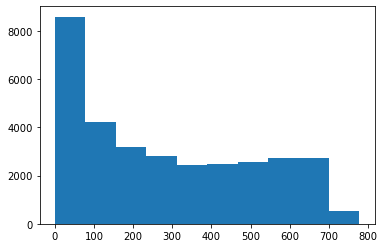

In [43]:
plt.hist(batting.pa);

Runs and Wins are cumulative, but we will want to eventually get them down to a rate stat to compare seasons with different numbers of games. Since 1957, baseball requires 3.1 `PA` per team game played in order to qualify for league leaders for rate stats like batting average. This should be instituted here as well which will also protect against outliers of players who performed really well or really poor for a short burst of time.

In [44]:
batting['pa_per_team_gp'] = batting.pa/batting.team_gp

In [45]:
batting = batting[batting.pa_per_team_gp >= 3.1]

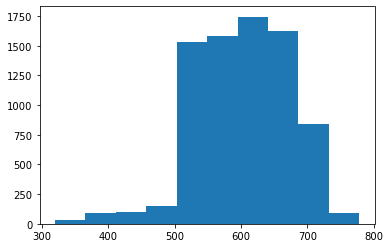

In [46]:
plt.hist(batting.pa);

Looking much better! As an aggregate function this won't be super useful. This will be dropped in favor of a PA per game feature later.

### `g`

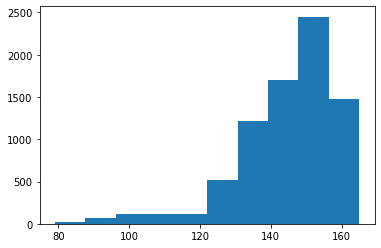

In [47]:
plt.hist(batting.g);

**Observation** There are some players that had 80-90 game seasons while still qualifying for the PA requirement. This requirement supersedes any game number requirement that may be had.

Keep this column to use to generate per-game rates.

In [48]:
# generate per game rates for accumulative stats
for i in ['pa','inn','runs_bat', 'runs_br', 'runs_dp', 'runs_defense',
          'runs_position', 'runs_above_avg','runs_above_avg_off',
          'runs_above_avg_def', 'waa', 'waa_off','waa_def', 'waa_pos']:
    
    batting[i] = batting[i] / batting['g']
    batting.rename(columns={i:i+'_pg'}, inplace=True)

## Target Variable `waa_pg`

We have finally arrived at our actual target! A per_game rate of `WAA`

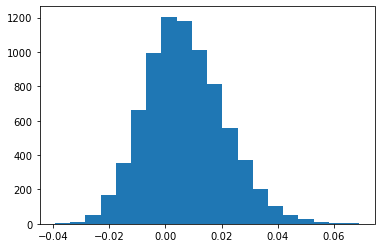

In [49]:
plt.hist(batting.waa_pg, bins=20);

This is approximately symmetric! This will be really fun to explore. The center is slightly above 0.00 which makes sense intuitively: players who get enough plate appearances should generally be better than the average player. Players who perform less-than-average over a long period of time would be benched or released.

WAA can be decomposed into the offensive and defensive component, `waa_off_pg` and `waa_def_pg` respectively. Along with a positional adjustment, `WAA` is a linear combination of these features:
```python
WAA_pg = WAA_off_pg + WAA_df_pg - WAA_pos_pg
```

Each of these features are made up of the underlying runs features. Since we only care about WAA_pg, the offensive and defensive components can be disregarded as their signal will be capture both by `waa_pg` and the underlying runs that formulate them.

In [50]:
# drop
batting.drop(['waa_off_pg', 'waa_def_pg', 'waa_pos_pg'],
             axis = 1,
             inplace=True)

## EDA with Target

### `year_id`

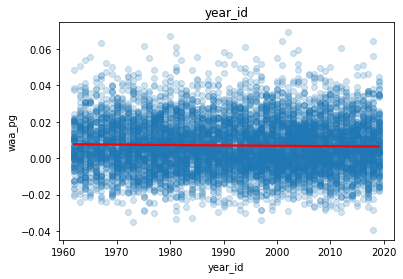

In [51]:
sns.regplot(x='year_id', y='waa_pg', data = batting,
            scatter_kws={'alpha': 0.2},
            line_kws={'color': 'red'}).set(title = 'year_id');

**Observed** The nature of our target is that each year_id performance is normalized within the year it took place. If all players were kept, we would expect the line to be at 0.00 waa_pg for the same reason discussed above in the histogram for waa_pg.

**Note** There is no real correlation here between waa_pg and year_id; however, it will be kept in the dataset for now. Features will be reduced later and it is expected that `year_id` will be one of them.

### `age`

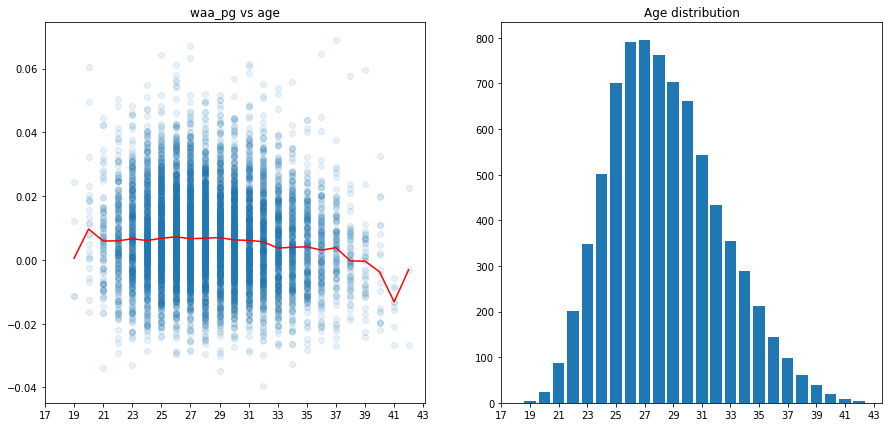

In [52]:
fig, ax = plt.subplots(1,2,figsize=(15,7))

ax[0].scatter(batting.age, batting.waa_pg, alpha=0.1)
ax[0].plot(batting.groupby('age').waa_pg.median(),
         color = 'red')
ax[0].set_xticks(range(17,45,2))
ax[0].set_title('waa_pg vs age')

ax[1].bar(batting.groupby('age').sum().index, batting.groupby('age').count().waa_pg)
ax[1].set_xticks(range(17,45,2))
ax[1].set_title('Age distribution');

**Observation** The `waa_pg` of a player tends downward as they age. The small amounts at both the beginning and end of the age spectrum should be removed as outliers.

In [53]:
batting = batting[(batting.age>20) & (batting.age<=39)]

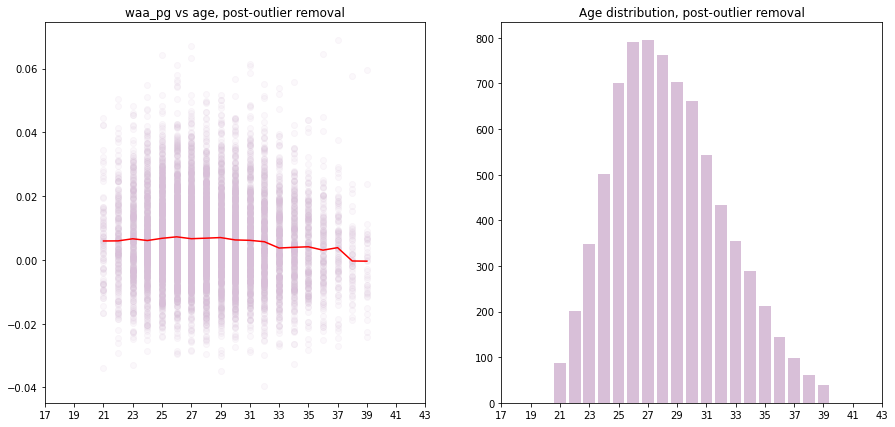

In [54]:
fig, ax = plt.subplots(1,2,figsize=(15,7))

ax[0].scatter(batting.age, batting.waa_pg, alpha=0.1, color='thistle')
ax[0].plot(batting.groupby('age').waa_pg.median(),
         color = 'red')
ax[0].set_xticks(range(17,45,2))
ax[0].set_title('waa_pg vs age, post-outlier removal')

ax[1].bar(batting.groupby('age').sum().index, batting.groupby('age').count().waa_pg, color='thistle')
ax[1].set_xticks(range(17,45,2))
ax[1].set_title('Age distribution, post-outlier removal');

## Lookback Variable EDA

In the next workbook, 02_Feature_Extraction, the dataframe will have a variety of features added as lookback variables. For example, we will not be modeling `waa_pg` as a function of `runs_bat_pg` because that would mean our season has already occurred. Instead, we care about modeling `waa_pg` as a function of `runs_bat_pg_1yr`, `runs_bat_pg_2yr`, `runs_bat_pg_3yr`, etc.

The graphs and observations in this section are just to understand the relationship between the variables within the same season. No features or outliers will be dropped here. Lookback EDA will be completed later.

### Game Participation Vars

As seen previously, if a player is getting a larger amount of plate appearances or playing in a larger amount of games, they tend to have higher waa_pg.

These metrics can be turned into rate-variables by looking at the number of games, pa, or innings a player averaged in relation to the total games their team played.

#### `percent_team_gp`

In [55]:
batting['percent_team_gp'] = batting.g / batting.team_gp

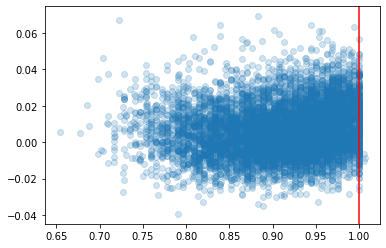

In [56]:
plt.scatter(batting.percent_team_gp,
            batting.waa_pg,
            alpha = 0.2)
plt.axvline(x=1, color='red');

**Observation** There are a number of players who appeared in more than 100% of their team games. This can be possible if a player changed teams in the season where the first team had played more games than the second

There is a loose positive correlation between `percent_team_gp` and `waa_pg`. This could indicate that players who tend to play a higher percentage of games are bound to be better overall.

#### `pa_per_team_gp`

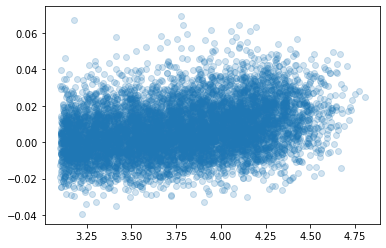

In [57]:
plt.scatter(batting.pa_per_team_gp,
            batting.waa_pg,
            alpha = 0.2)

**Observation** The hard cutoff at 3.1 we instituted previously can be seen and players who tend to get a higher amount of plate appearances per team game tend to have higher waa_pg

#### `inn_pg`

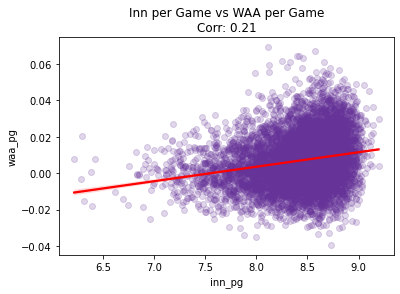

In [58]:
sns.regplot(x='inn_pg', y='waa_pg',
            data = batting,
            scatter_kws={'alpha': 0.2,
                         'color': 'rebeccapurple'},
            line_kws={'color': 'red'})\
.set(title='Inn per Game vs WAA per Game\nCorr: '+\
            str(round(batting.corr().loc['waa_pg','inn_pg'],4)));

**Observation** Similar to `percent_team_gp`, players who play a larger average number of innings per game would tend to be better overall. This can be seen through the loose positive correlation.

#### `inn_per_team_gp`

In [59]:
# create inn_per_team_gp
batting['inn_per_team_gp'] = batting.inn_pg * batting.g / batting.team_gp

<AxesSubplot:xlabel='inn_per_team_gp', ylabel='waa_pg'>

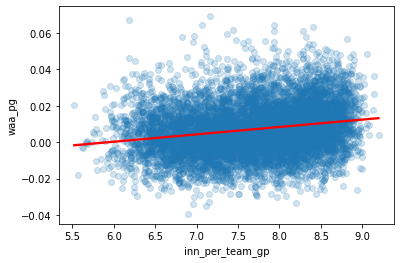

In [60]:
sns.regplot(x='inn_per_team_gp', y='waa_pg',
            data = batting,
            scatter_kws={'alpha': 0.2},
            line_kws={'color': 'red'})

**Observation** Continuting with the theme, players who play a larger average number of innings per team game would tend to be better overall.

### runs variables

Runs are the building blocks of wins and they can be added many different ways besides the batter box.

The dataset currently has a few redundancies:
  -  `runs_above_avg_pg`: This is the linear combination `runs_bat_pg` + `runs_br_pg` + `runs_dp_pg` + `runs_defense_pg` + `runs_position_pg`
  -  `runs_above_avg_off_pg`: This is the linear combination `runs_bat_pg` + `runs_br_pg` + `runs_dp_pg` + `runs_position_pg`
  -  `runs_above_avg_def_pg`: This is the linear combination `runs_defense_pg` + `runs_position_pg`

In [61]:
# drop the combination features
batting.drop(['runs_above_avg_pg', 
              'runs_above_avg_off_pg', 
              'runs_above_avg_def_pg'],
            axis = 1,
            inplace=True)

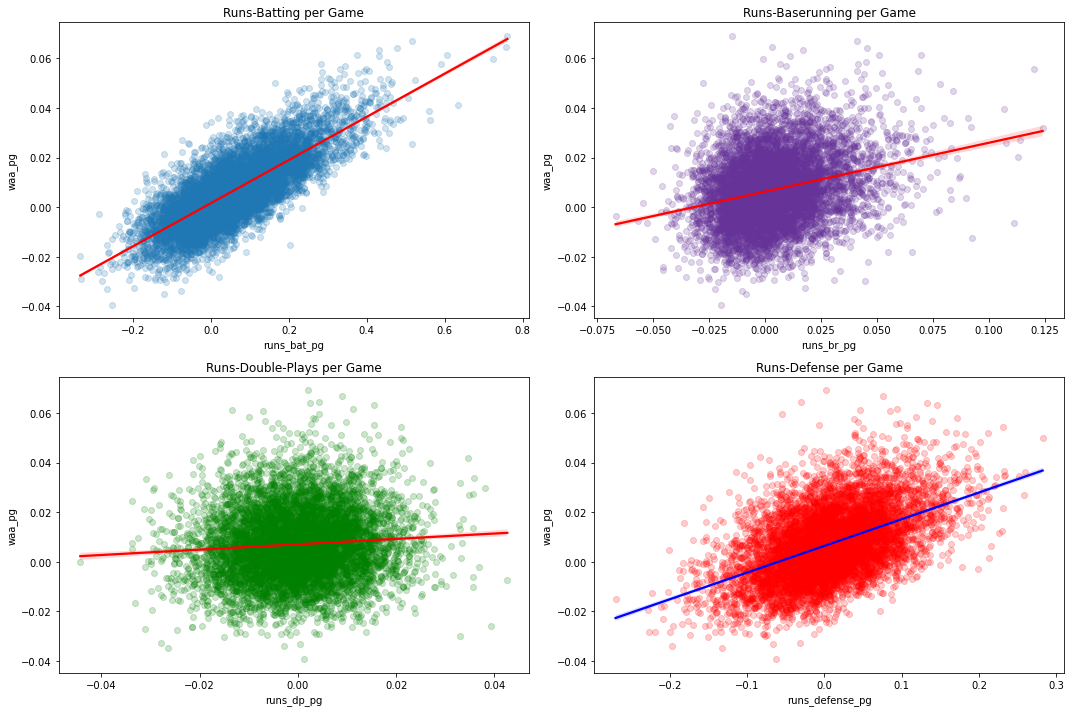

In [62]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

sns.regplot(x='runs_bat_pg', y='waa_pg', data = batting,
            scatter_kws={'alpha': 0.2},
            line_kws={'color': 'red'},
            ax = ax[0][0]).set(title = 'Runs-Batting per Game')

sns.regplot(x='runs_br_pg', y='waa_pg', data = batting,
            scatter_kws={'alpha': 0.2,
                         'color': 'rebeccapurple'},
            line_kws={'color': 'red'},
            ax = ax[0][1]).set(title = 'Runs-Baserunning per Game')

sns.regplot(x='runs_dp_pg', y='waa_pg', data = batting,
            scatter_kws={'alpha': 0.2,
                         'color': 'green'},
            line_kws={'color': 'red'},
            ax = ax[1][0]).set(title = 'Runs-Double-Plays per Game')

sns.regplot(x='runs_defense_pg', y='waa_pg', data = batting,
            scatter_kws={'alpha': 0.2,
                         'color': 'red'},
            line_kws={'color': 'blue'},
            ax = ax[1][1]).set(title = 'Runs-Defense per Game')

plt.tight_layout();

**Observation** These four segments of the overall runs_above_avg_pg metric are pretty straightforward. It's a cumulative measure, so the better you do, the more runs you get, the more WAA you will have. 

One way to see the importance of each part is to look at the steepness of the line; here `runs_bat_pg` and `runs_defense_pg` are the most steep followed by `runs_br_pg` and lastly `runs_dp_pg`. The second thing to keep in mind is the scale of the x-axis, the range of runs offered by `runs_bat_pg` and `runs_defense_pg` are similar, while the other two are a factor of 10 smaller.

Another way to visualize this is to graph them all together

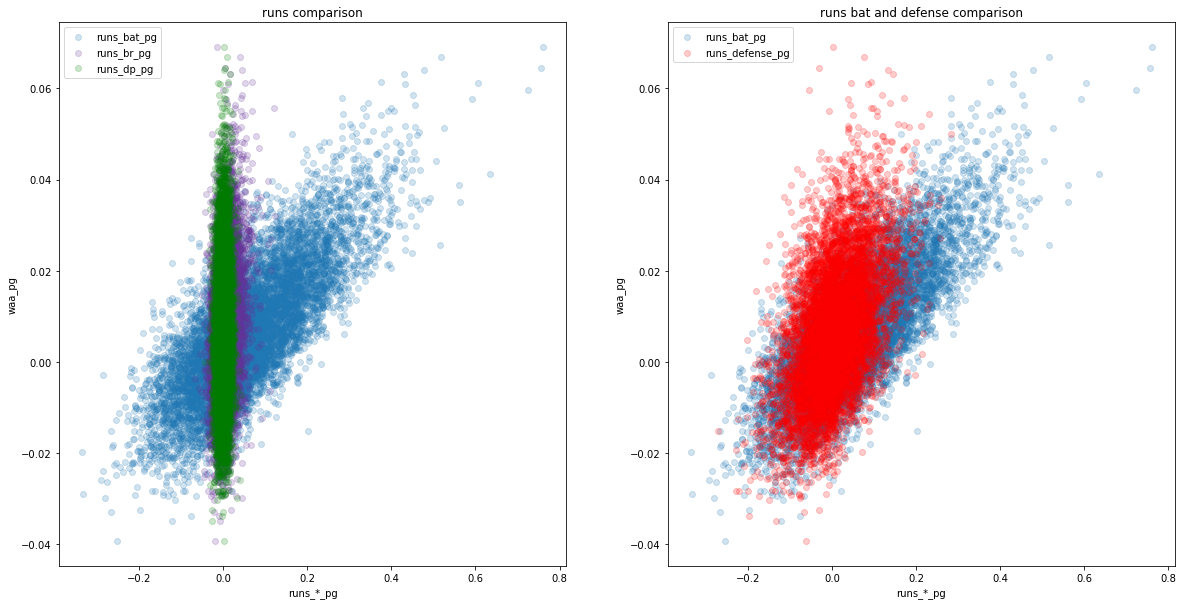

In [63]:
fig, ax = plt.subplots(1,2,figsize=(20,10))

ax[0].scatter(batting.runs_bat_pg, batting.waa_pg,
            alpha = 0.2,
            label = 'runs_bat_pg')
ax[0].scatter(batting.runs_br_pg, batting.waa_pg,
            alpha = 0.2, color = 'rebeccapurple',
            label = 'runs_br_pg')
ax[0].scatter(batting.runs_dp_pg, batting.waa_pg,
            alpha = 0.2, color = 'green',
            label = 'runs_dp_pg')
ax[0].set_ylabel('waa_pg')
ax[0].set_xlabel('runs_*_pg')
ax[0].set_title('runs comparison')
ax[0].legend()

ax[1].scatter(batting.runs_bat_pg, batting.waa_pg,
            alpha = 0.2,
            label = 'runs_bat_pg')
ax[1].scatter(batting.runs_defense_pg, batting.waa_pg,
            alpha = 0.2, color = 'red',
            label = 'runs_defense_pg')
ax[1].set_ylabel('waa_pg')
ax[1].set_xlabel('runs_*_pg')
ax[1].set_title('runs bat and defense comparison')
ax[1].legend();

**Observation** The range of `runs_br_pg` and `runs_dp_pg` are very narrow compared to `runs_bat_pg` and `runs_defense_pg`.

#### `runs_position_pg`

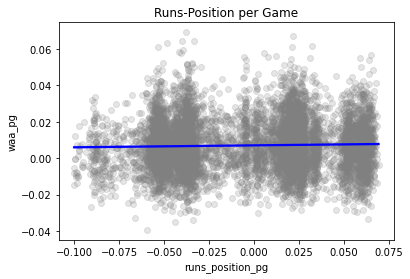

In [64]:
sns.regplot(x='runs_position_pg', y='waa_pg', data = batting,
            scatter_kws={'alpha': 0.2,
                         'color': 'grey'},
            line_kws={'color': 'blue'}).set(title = 'Runs-Position per Game');

**Observation** Unlike the other portions of runs, `runs_position_pg` is uncorrelated with `waa_pg`. This makes sense when considering what `runs_position_pg` is calculated as a position-dependent metric that provides a set value. Each position, regardless of performance, will get a runs amount. In the graph above, several clusters can be made out.

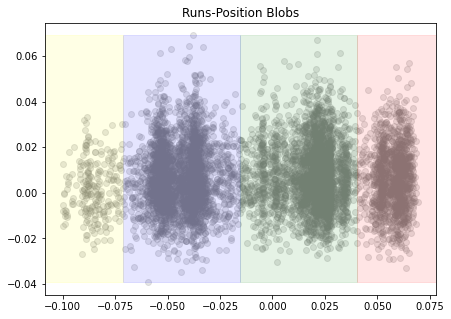

In [65]:
fig, ax = plt.subplots(1,1,figsize=(7,5))

ax.scatter(batting.runs_position_pg, batting.waa_pg,
            alpha= 0.2,
            color= 'grey')
ax.set_title('Runs-Position Blobs')
ax.axhspan(xmin = 0,
           xmax = .20,
           ymin = batting.waa_pg.min(),
           ymax = batting.waa_pg.max(),
           color = 'yellow',
           alpha = 0.1)
ax.axhspan(xmin = .20,
           xmax = .50,
           ymin = batting.waa_pg.min(),
           ymax = batting.waa_pg.max(),
           color = 'blue',
           alpha = 0.1)
ax.axhspan(xmin = .50,
           xmax = .80,
           ymin = batting.waa_pg.min(),
           ymax = batting.waa_pg.max(),
           color = 'green',
           alpha = 0.1)
ax.axhspan(xmin = .80,
           xmax = 1,
           ymin = batting.waa_pg.min(),
           ymax = batting.waa_pg.max(),
           color = 'red',
           alpha = 0.1)

The blue section could be split again, as the green, but the point is that each of these has a range of `waa_pg` values. This indicates that each positional adjustment has a range of `waa_pg` values.

Intuitively, this makes sense, an outfielder can generate as many `waa_pg` as a catcher, but the underlying `runs_position_pg` will be much different! The baseball-reference formula *adds* runs by virtue of being a catcher, while it *removes* runs by virtue of being an outfielder.

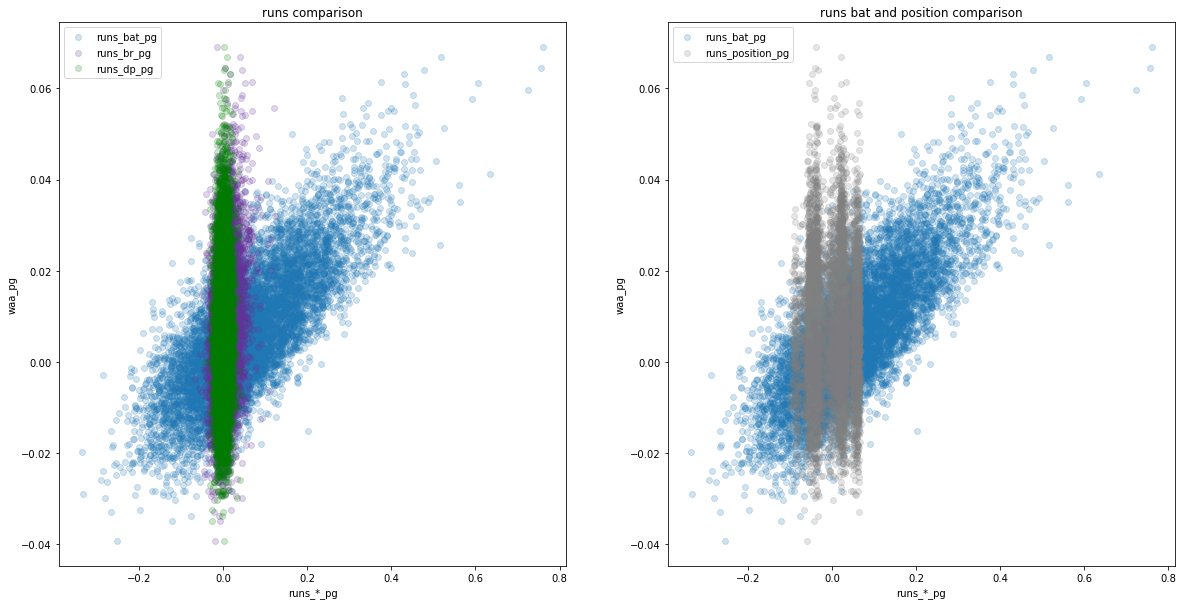

In [66]:
fig, ax = plt.subplots(1,2,figsize=(20,10))

ax[0].scatter(batting.runs_bat_pg, batting.waa_pg,
            alpha = 0.2,
            label = 'runs_bat_pg')
ax[0].scatter(batting.runs_br_pg, batting.waa_pg,
            alpha = 0.2, color = 'rebeccapurple',
            label = 'runs_br_pg')
ax[0].scatter(batting.runs_dp_pg, batting.waa_pg,
            alpha = 0.2, color = 'green',
            label = 'runs_dp_pg')
ax[0].set_ylabel('waa_pg')
ax[0].set_xlabel('runs_*_pg')
ax[0].set_title('runs comparison')
ax[0].legend()

ax[1].scatter(batting.runs_bat_pg, batting.waa_pg,
            alpha = 0.2,
            label = 'runs_bat_pg')
ax[1].scatter(batting.runs_position_pg, batting.waa_pg,
            alpha = 0.2, color = 'grey',
            label = 'runs_position_pg')
ax[1].set_ylabel('waa_pg')
ax[1].set_xlabel('runs_*_pg')
ax[1].set_title('runs bat and position comparison')
ax[1].legend();

The band is slightly wider than `runs_dp_pg` and `runs_br_pg`

## Final Touches

In [67]:
# reorder columns
batting = batting.reindex(columns=\
                    ['waa_pg',
                     'player_id','year_id','name_common', 'age',
                     'g','team_gp','pa_pg','inn_pg', 
                     'runs_bat_pg', 'runs_br_pg', 'runs_dp_pg',
                     'runs_defense_pg','runs_position_pg', 
                     'opprpg',
                     'percent_team_gp', 'pa_per_team_gp','inn_per_team_gp'])

# Positions EDA

## Getting Shares

`runs_position_pg` introduced the idea of a position-based weight being applied toward WAA. While that feature by itself does a good job encapsulating the effect, let's add some signal for the positions these players are playing in order to get those weights.

A player receives a new line for each team played per season. Need to aggregate by `experience` similar to `stint_id` in batting.

In [68]:
positions = positions.groupby(['player_id','year_id']).sum()\
                [['g_all','g_p', 'g_c', 'g_1b', 'g_2b', 'g_3b', 'g_ss','g_lf', 'g_cf',
                  'g_rf', 'g_of', 'g_dh']].reset_index()

Ultimately, we are interested in the amount of time spent at each *defensive* position. To accomplish this, divide each positional feature by `g_all` to get a percentage.

Note: a player can play multiple positions in a game. These percentages will sum up to more than 1 at first and will also treat 1 inning at 1B and 8 innings at RF as the same weight.

In [69]:
for i in ['g_p', 'g_c', 'g_1b', 'g_2b', 'g_3b', 'g_ss','g_lf', 'g_cf',
          'g_rf', 'g_dh']:
    
    positions[i] = positions[i] / positions.g_all
    positions.rename(columns={i: i+'_share'},
                     inplace=True)

One last caveat, since we removed pitchers from the batting dataset, we don't really care about `g_p` anymore. Batters can have appearances as pitchers during blowouts, etc, but those effects will be measured in their pitching waa which is a different dataset.

In [70]:
positions.drop('g_p_share', axis=1, inplace=True)


We are interested in the percent of games a player spends at each position. To accomplish this, normalize each row to sum to 1.

In [71]:
# normalize all g_*_share columns to sum to 1
share_cols = ['g_c_share', 'g_1b_share',
       'g_2b_share', 'g_3b_share', 'g_ss_share', 'g_lf_share', 'g_cf_share',
       'g_rf_share', 'g_dh_share']


g_share_sum = positions[share_cols].sum(axis=1)

for i in share_cols:
    positions[i] = positions[i] / g_share_sum
    
# no longer needed
positions.drop('g_all', axis=1, inplace=True)

In [72]:
# merge into batting to get a final dataframe batpos
batpos = pd.merge(batting,positions,
             on = ['year_id','player_id'])

### `_share` check

With pitchers from `positions` not carried over via the merge/join, confirm that every batter has a sum `g_*_share` equal to 1 

In [73]:
g_share_sum = batpos[share_cols].sum(axis=1)
g_share_sum.value_counts(normalize=True)

1.0    0.884112
1.0    0.080409
1.0    0.027839
1.0    0.007640
dtype: float64

**Observation** All batters have a `g_*_share` value of 1 within a rounding error

## `share` overview

### Catcher Share

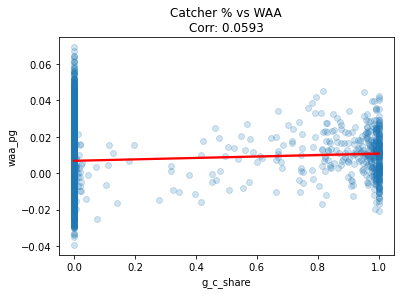

In [74]:
sns.regplot(x='g_c_share', y='waa_pg',
            data = batpos,
            scatter_kws={'alpha': 0.2},
            line_kws={'color': 'red'})\
.set(title='Catcher % vs WAA\nCorr: '+\
            str(round(batpos.corr().loc['waa_pg','g_c_share'],4)));

**Observation** Playing catcher tends to increase `waa_pg`

### 1B, 3B Shares

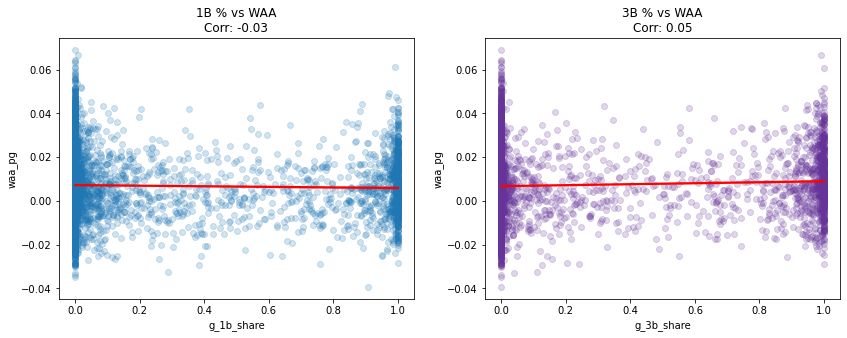

In [75]:
fig, ax = plt.subplots(1,2,figsize=(14,4.8))
sns.regplot(x='g_1b_share', y='waa_pg',
            data = batpos,
            scatter_kws={'alpha': 0.2},
            line_kws={'color': 'red'},
            ax = ax[0])\
.set(title='1B % vs WAA\nCorr: '+\
            str(round(batpos.corr().loc['waa_pg','g_1b_share'],4)))

sns.regplot(x='g_3b_share', y='waa_pg',
            data = batpos,
            scatter_kws={'alpha': 0.2,
                         'color': 'rebeccapurple'},
            line_kws={'color': 'red'},
            ax = ax[1])\
.set(title='3B % vs WAA\nCorr: '+\
            str(round(batpos.corr().loc['waa_pg','g_3b_share'],4)));

**Observation** Playing 1B tends to have a negative effect on `waa_pg`, playing 3B tends to have a positive effect on `waa_pg`

### 2B, SS Shares

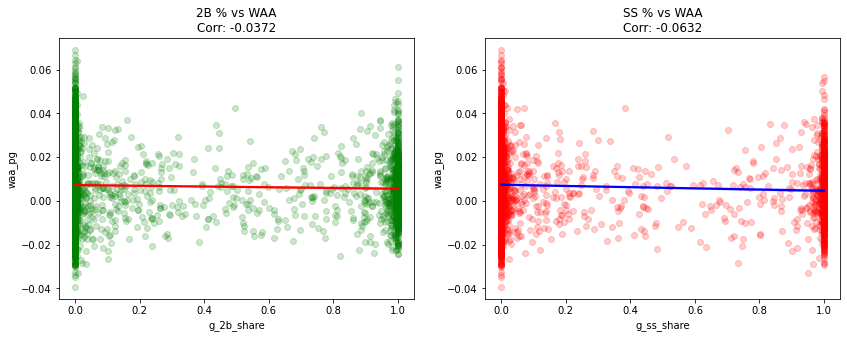

In [76]:
fig, ax = plt.subplots(1,2,figsize=(14,4.8))
sns.regplot(x='g_2b_share', y='waa_pg',
            data = batpos,
            scatter_kws={'alpha': 0.2,
                         'color': 'green'},
            line_kws={'color': 'red'},
            ax = ax[0])\
.set(title='2B % vs WAA\nCorr: '+\
            str(round(batpos.corr().loc['waa_pg','g_2b_share'],4)))

sns.regplot(x='g_ss_share', y='waa_pg',
            data = batpos,
            scatter_kws={'alpha': 0.2,
                         'color': 'red'},
            line_kws={'color': 'blue'},
            ax = ax[1])\
.set(title='SS % vs WAA\nCorr: '+\
            str(round(batpos.corr().loc['waa_pg','g_ss_share'],4)));

**Observation** Playing both 2B and SS tend to have a negative effect on `waa_pg`, with SS having a slightly more negative effect.

### Outfield Shares

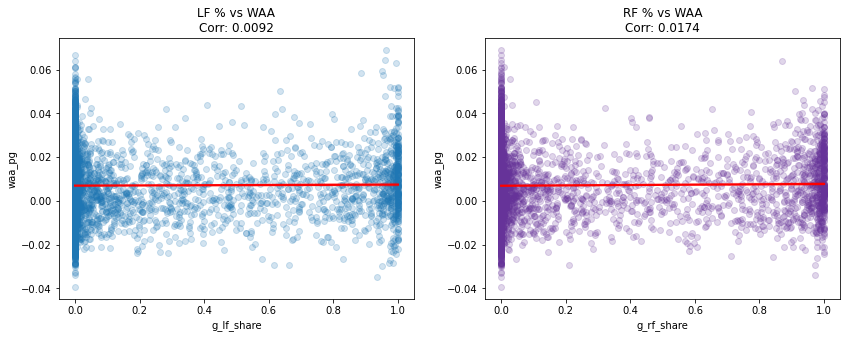

In [77]:
fig, ax = plt.subplots(1,2,figsize=(14,4.8))
sns.regplot(x='g_lf_share', y='waa_pg',
            data = batpos,
            scatter_kws={'alpha': 0.2},
            line_kws={'color': 'red'},
            ax = ax[0])\
.set(title='LF % vs WAA\nCorr: '+\
            str(round(batpos.corr().loc['waa_pg','g_lf_share'],4)))

sns.regplot(x='g_rf_share', y='waa_pg',
            data = batpos,
            scatter_kws={'alpha': 0.2,
                         'color': 'rebeccapurple'},
            line_kws={'color': 'red'},
            ax = ax[1])\
.set(title='RF % vs WAA\nCorr: '+\
            str(round(batpos.corr().loc['waa_pg','g_rf_share'],4)));

**Observation** Playing LF or RF tend to have no effect on `waa_pg`

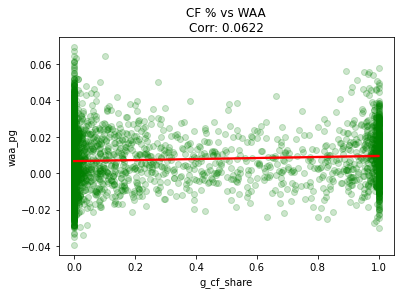

In [78]:
sns.regplot(x='g_cf_share', y='waa_pg',
            data = batpos,
            scatter_kws={'alpha': 0.2,
                         'color': 'green'},
            line_kws={'color': 'red'})\
.set(title='CF % vs WAA\nCorr: '+\
            str(round(batpos.corr().loc['waa_pg','g_cf_share'],4)));

**Observation** Playing CF or the generalized OF tend to have a positive effect on `waa_pg`


Since LF and RF are so close in their relationships with `waa_pg`, combine them into `waa_cof_share` where cof means corner infield.

In [79]:
batpos['g_cof_share'] = batpos['g_lf_share']+batpos['g_rf_share']
batpos.drop(['g_lf_share','g_rf_share'],
            axis=1,
            inplace=True)

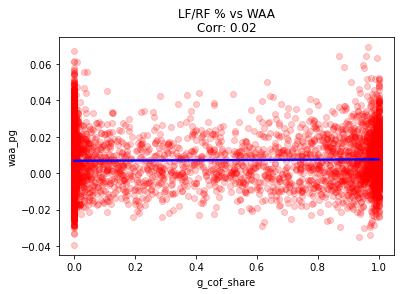

In [80]:
sns.regplot(x='g_cof_share', y='waa_pg',
            data = batpos,
            scatter_kws={'alpha': 0.2,
                         'color': 'red'},
            line_kws={'color': 'blue'})\
.set(title='LF/RF % vs WAA\nCorr: '+\
            str(round(batpos.corr().loc['waa_pg','g_cof_share'],4)));

**Observation** when combined, the correlation is greater than either of the individual positions.

### DH Shares

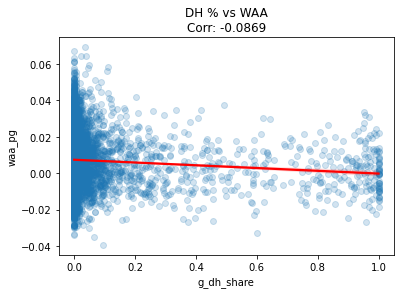

In [81]:
sns.regplot(x='g_dh_share', y='waa_pg',
            data = batpos,
            scatter_kws={'alpha': 0.2},
            line_kws={'color': 'red'})\
.set(title='DH % vs WAA\nCorr: '+\
            str(round(batpos.corr().loc['waa_pg','g_dh_share'],4)));

**Observation** Playing DH has quite a stark negative effect on `waa_pg`

# Exports

**Final shape of our dataset after EDA:**

7723 rows, 26 features, 1 target

In [82]:
batpos.to_csv('../data/batpos_eda.csv', index=False)